In [ ]:
# !pip install dimod
# !pip install pandas
# !pip install matplotlib


## Phase 1: Setup, Data Loading, and Parameter Definition.
This code will import our libraries, load the smart_grid_dataset_2024.csv file, and set up all the "Given" parameters from our problem. This cell is almost identical to the original, just with the PennyLane/JAX imports removed.

In [1]:
# Step 1: Setup, Data Loading, and Parameter Definition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Suppress warnings for cleaner output
def warn (*args, **kwargs):
    pass
import warnings
warnings.filterwarnings('ignore')

print("Phase 1: Setup & Data Preparation")

#  1. Load Data 
try:
    df = pd.read_csv("smart_grid_dataset_2024.csv")
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
except FileNotFoundError:
    print("ERROR: 'smart_grid_dataset_2024.csv' not found.")
    # In a real notebook, we'd stop execution here

#  2. Create Time-Series Arrays (The "Givens") 
# Filter for our 24-hour period (Jan 1, 2024)
df_24h = df[df['Timestamp'].dt.date == pd.to_datetime('2024-01-01').date()].copy()

if len(df_24h) != 96:
    print(f"Warning: Expected 96 time steps, but found {len(df_24h)}.")

# Total time steps (T = 96)
T = len(df_24h) 

# B_t: Baseline Load (kW)
B_t = df_24h['Power Consumption (kW)'].values

# C_t: Energy Price (USD/kWh)
C_t = df_24h['Electricity Price (USD/kWh)'].values

# R_t: Renewable Production (kW)
R_t = (df_24h['Solar Power (kW)'] + df_24h['Wind Power (kW)']).values

print(f"Data loaded for {T} time steps.")

# 3. Define Appliance Parameters (The "Problem Space") 
# --- THIS IS THE UPDATED (UN-PRUNED) SECTION ---
# We are now using all valid 15-minute start times.

print("Using FULL Appliance Parameters (for 101 variables)")

appliances = {
    'ev_charger': {
        'P': 9.0,  # kW
        'L': 16,   # 16 steps = 4 hours
        # Window: 10:00 PM (88) to 6:00 AM (ends at step 23)
        'window': list(range(88, 96)) + list(range(0, 24 - 16 + 1)) 
    },
    'washing_machine': {
        'P': 1.5,  # kW
        'L': 4,    # 4 steps = 1 hour
        # Window: 8:00 AM (32) to 10:00 PM (ends at step 87)
        'window': list(range(32, 88 - 4 + 1))
    },
    'dishwasher': {
        'P': 1.8,  # kW
        'L': 6,    # 6 steps = 1.5 hours
        # Window: 8:00 PM (80) to 5:00 AM (ends at step 19)
        'window': list(range(80, 96)) + list(range(0, 20 - 6 + 1))
    }
}

print("Appliance parameters (full) are now defined.")
print("Phase 1 Complete \n")

Phase 1: Setup & Data Preparation
Data loaded for 96 time steps.
Using FULL Appliance Parameters (for 101 variables)
Appliance parameters (full) are now defined.
Phase 1 Complete 



## Phase 2: Building the QUBO
This is the main change. Instead of building an Ising Hamiltonian ($H$) for QAOA, we will build the QUBO matrix ($Q$) directly. The objective function is: $E(x) = \sum_i Q_{i,i} x_i + \sum_{i<j} Q_{i,j} x_i x_j$ We will build the $Q$ dictionary, which dimod (D-Wave's library) understands.

In [2]:
import dimod

print("\n Phase 2: Building the QUBO \n")

#  4. Define Variable Mapping (Decision Variables) 
# We map each possible start time for each appliance to a unique variable index.
# x_{i,t} -> var_index

var_map = {} # {('appliance_name', start_time): var_index}
reverse_map = {} # {var_index: ('appliance_name', start_time)}
current_var_index = 0

for app_name, details in appliances.items():
    for start_time in details['window']:
        var_map[(app_name, start_time)] = current_var_index
        reverse_map[current_var_index] = (app_name, start_time)
        current_var_index += 1

n_vars = len(var_map)
print(f"Total number of decision variables: {n_vars}")

# --- 5. Define Hyperparameters (A, B, C) ---\
# These are the weights for our objective function
A = 1.0  # Weight for Cost
B = 1.5  # Weight for Peak Load

# --- UPDATE HERE ---
# C must be much larger than A or B to enforce the constraint.
# Let's increase it significantly.
C = 100000.0 # Was 5000.0
print(f"Hyperparameters: A={A}, B={B}, C={C}")

# --- 6. Build QUBO Coefficients (Q) ---
# We build the coefficients for the QUBO model:
# E = x^T Q x = sum_i(Q_ii * x_i) + sum_{i<j}(Q_ij * x_i * x_j) + Offset
# We will use a dictionary for Q: Q = {(i, j): coefficient}

Q = {}
offset = 0.0

# 6a. H_cost_term (Linear)
# H_cost = A * sum_{i,t} (C_{i,t} * x_{i,t})
# This adds linear (diagonal) terms to Q.
print("Building H_cost...")
for (app_name, start_time), var_idx in var_map.items():
    app = appliances[app_name]
    P = app['P']
    L = app['L']
    
    # Pre-calculate the cost C_{i,t} for this start time
    cost_of_run = 0.0
    for t in range(start_time, start_time + L):
        cost_of_run += C_t[t % T] # Use modulo T for midnight wrap-around
    
    C_i_t = P * cost_of_run
    
    # Term is A * C_i_t * x_i
    # This is a linear term, so it goes on the diagonal Q[i, i]
    Q_key = (var_idx, var_idx)
    Q[Q_key] = Q.get(Q_key, 0.0) + (A * C_i_t)

# 6b. H_constraint_term (Quadratic)
# H_constraint = C * sum_i ( (sum_t(x_{i,t}) - 1)^2 )
# This penalizes any appliance for running 0 times or >1 time.
# (sum_t(x) - 1)^2 = (sum_t(x))^2 - 2*sum_t(x) + 1
# (sum_t(x))^2 = sum_t(x_t^2) + 2*sum_{t<t'}(x_t*x_t')
# Since x is binary, x_t^2 = x_t.
# (sum_t(x))^2 = sum_t(x_t) + 2*sum_{t<t'}(x_t*x_t')
# So, (sum_t(x) - 1)^2 = (sum_t(x_t) + 2*sum_{t<t'}(x_t*x_t')) - 2*sum_t(x_t) + 1
# H_constraint = C * sum_i ( 2*sum_{t<t'}(x_{i,t}*x_{i,t'}) - sum_t(x_{i,t}) + 1 )
#
print("Building H_constraint...")
for app_name, app_details in appliances.items():
    app_vars = [var_map[(app_name, t)] for t in app_details['window']]
    
    # Add constant offset term: C * sum_i(1)
    offset += C
    
    # Add linear term: -C * sum_i(sum_t(x_{i,t}))
    for var_idx in app_vars:
        Q_key = (var_idx, var_idx)
        Q[Q_key] = Q.get(Q_key, 0.0) - C
        
    # Add quadratic term: 2*C * sum_i(sum_{t<t'}(x_{i,t}*x_{i,t'}))
    for i in range(len(app_vars)):
        for j in range(i + 1, len(app_vars)):
            q_i = app_vars[i]
            q_j = app_vars[j]
            
            # Key must be (min_idx, max_idx)
            Q_key = tuple(sorted((q_i, q_j)))
            Q[Q_key] = Q.get(Q_key, 0.0) + (2 * C)

# 6c. H_peak_term (Quadratic)
# H_peak = B * sum_t ( (B_t + L_deferrable(t) - R_t)^2 )
# H_peak = B * sum_t ( (L_deferrable(t) + (B_t - R_t))^2 )
# Let N_t = (B_t - R_t) and L_def(t) = sum_i(P_i * x_i)
# H_peak = B * sum_t ( L_def(t)^2 + 2*L_def(t)*N_t + N_t^2 )
#
print("Building H_peak...")
for t in range(T):
    # Constant term: B * N_t^2
    net_baseline = B_t[t] - R_t[t]
    offset += B * (net_baseline ** 2)
    
    # Find all x_{i,k} that are 'ON' at time t
    L_def_terms = [] # List of (var_index, power_P_i)
    for (app_name, start_time), var_idx in var_map.items():
        app = appliances[app_name]
        P = app['P']
        L = app['L']
        
        # Check if an appliance starting at 'start_time' is ON at time 't'
        is_on = False
        if start_time + L > T: # Wraps around
            if (t >= start_time) or (t < (start_time + L) % T):
                is_on = True
        else: # Does not wrap
            if (t >= start_time) and (t < start_time + L):
                is_on = True
        
        if is_on:
            L_def_terms.append((var_idx, P))

    # Linear term: B * 2 * L_def(t) * N_t
    # Term = 2 * B * N_t * sum(P_i * x_i)
    for var_idx, P_i in L_def_terms:
        # Term is (2 * B * net_baseline * P_i) * x_i
        coeff = B * 2 * net_baseline * P_i
        Q_key = (var_idx, var_idx)
        Q[Q_key] = Q.get(Q_key, 0.0) + coeff

    # Quadratic term: B * (L_def(t)^2)
    # Term = B * (sum(P_i * x_i))^2
    # Term = B * (sum_i( (P_i*x_i)^2 ) + 2*sum_{i<j}( P_i*P_j*x_i*x_j ))
    # Since x_i^2 = x_i (binary):
    # Term = B * (sum_i( P_i^2 * x_i ) + 2*sum_{i<j}( P_i*P_j*x_i*x_j ))
    
    # Quadratic's linear part: B * sum_i( P_i^2 * x_i )
    for var_idx, P_i in L_def_terms:
        # Term is B * P_i^2 * x_i
        coeff = B * (P_i**2)
        Q_key = (var_idx, var_idx)
        Q[Q_key] = Q.get(Q_key, 0.0) + coeff

    # Quadratic's quadratic part: B * 2 * sum_{i<j}( P_i*P_j*x_i*x_j )
    for i in range(len(L_def_terms)):
        for j in range(i + 1, len(L_def_terms)):
            q_i, P_i = L_def_terms[i]
            q_j, P_j = L_def_terms[j]
            
            # Term is 2 * B * P_i * P_j * x_i * x_j
            coeff = B * 2 * P_i * P_j
            
            Q_key = tuple(sorted((q_i, q_j)))
            Q[Q_key] = Q.get(Q_key, 0.0) + coeff

# Count terms
linear_terms = len([k for k in Q.keys() if k[0] == k[1]])
quadratic_terms = len(Q) - linear_terms

print(f"Built QUBO with {linear_terms} linear terms")
print(f"and {quadratic_terms} quadratic terms.")
print(f"Constant Offset: {offset}")
print("Phase 2 Complete \n")


 Phase 2: Building the QUBO 

Total number of decision variables: 101
Hyperparameters: A=1.0, B=1.5, C=100000.0
Building H_cost...
Building H_constraint...
Building H_peak...
Built QUBO with 101 linear terms
and 2327 quadratic terms.
Constant Offset: 513902.1284809388
Phase 2 Complete 



## Phase 3: Solve with Simulated Annealing
This block replaces the QAOA circuit definition and optimization loop. We instantiate D-Wave's neal sampler and ask it to solve the QUBO problem we just built.

In [3]:
import time

print("\n Phase 3: Solve QUBO with Simulated Annealing \n")

# 1. Initialize the Neal sampler
sampler = dimod.SimulatedAnnealingSampler()

# 2. Run the optimization
print(f"Solving QUBO with D-Wave Neal ({n_vars} variables)...")
start_time = time.time()

# num_reads=100 asks the annealer for 100 potential solutions
# It will return the best one it found.
sampleset = sampler.sample_qubo(Q, num_reads=100)

end_time = time.time()
print(f"Solving complete in {end_time - start_time:.2f} seconds.")

# 3. Get the best solution
best_solution = sampleset.first.sample
best_energy = sampleset.first.energy

print(f"\nBest solution energy (from annealer): {best_energy:.2f}")
print(f"Total energy (with offset): {best_energy + offset:.2f}")

# Convert the dictionary solution {0: 1, 1: 0, ...} to a binary string
# for easy comparison with the original notebook.
best_solution_str = "".join([str(best_solution[i]) for i in range(n_vars)])
print(f"Best solution (binary): {best_solution_str}")
print("Phase 3 Complete \n")


 Phase 3: Solve QUBO with Simulated Annealing 

Solving QUBO with D-Wave Neal (101 variables)...
Solving complete in 303.26 seconds.

Best solution energy (from annealer): -315985.56
Total energy (with offset): 197916.57
Best solution (binary): 00000000000100000000000000000000000000000000000000000000000010000000000000000000000000000000000000010
Phase 3 Complete 



## Phase 4: Analyze and Visualize Results
This cell is the same as Phase 5 from the original notebook. It decodes the binary solution from the sampler and uses matplotlib to create the same visualization you requested.


 Phase 4: Analyze and Visualize Results 

Solution is VALID. Decoding schedule...

 Optimized Schedule 

  ev_charger: Start at time step 3
  washing_machine: Start at time step 75
  dishwasher: Start at time step 13
Total deferrable cost: $55.70
Generating final schedule plot...
Saved final schedule plot to 'qaoa_neal_final_schedule_full_v2.png'
Phase 4 Complete 



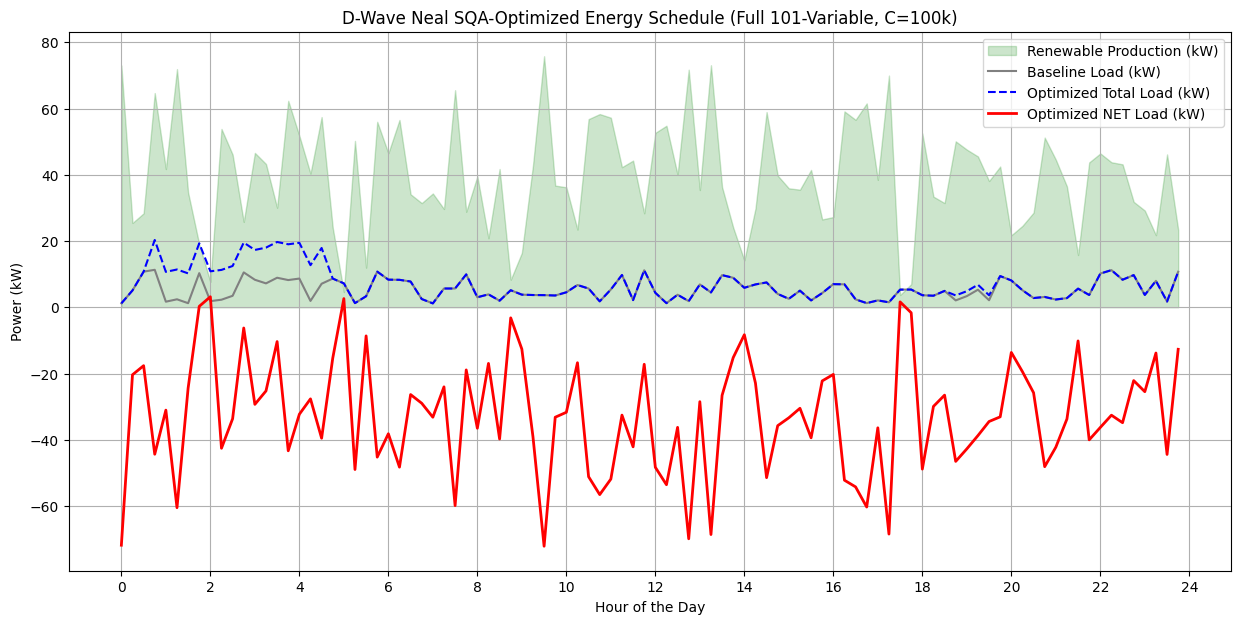

In [4]:
print("\n Phase 4: Analyze and Visualize Results \n")

# --- 18. Validate and Decode the Solution ---
schedule = {
    'ev_charger': {'start': -1, 'P': 9.0, 'L': 16},
    'washing_machine': {'start': -1, 'P': 1.5, 'L': 4},
    'dishwasher': {'start': -1, 'P': 1.8, 'L': 6}
}
total_cost = 0.0
valid_schedule = True
app_counts = {'ev_charger': 0, 'washing_machine': 0, 'dishwasher': 0}

# --- Validation Step ---
# First, count the 'on' bits for each appliance
for var_idx, bit in best_solution.items():
    if bit == 1:
        app_name, start_time = reverse_map[var_idx]
        app_counts[app_name] += 1

# Check if any constraint was broken
for app_name, count in app_counts.items():
    if count != 1:
        print(f"ERROR: Constraint broken for {app_name}! Found {count} start times.")
        valid_schedule = False

# --- Decoding Step ---
if valid_schedule:
    print("Solution is VALID. Decoding schedule...")
    for var_idx, bit in best_solution.items():
        if bit == 1:
            app_name, start_time = reverse_map[var_idx]
            schedule[app_name]['start'] = start_time
            
            # Calculate cost of this run
            app = appliances[app_name]
            P, L = app['P'], app['L']
            cost_of_run = sum(C_t[t % T] for t in range(start_time, start_time + L))
            total_cost += P * cost_of_run
else:
    print("ERROR: Solution is INVALID. The schedule below will be empty or incomplete.")
    print("Try increasing the penalty 'C' in Phase 2 even more.")

print("\n Optimized Schedule \n")
for app_name, details in schedule.items():
    if details['start'] != -1:
        print(f"  {app_name}: Start at time step {details['start']}")
    else:
        print(f"  {app_name}: NOT SCHEDULED")
        
print(f"Total deferrable cost: ${total_cost:.2f}")


# --- 19. Build Final Load Profile ---
optimized_load = np.zeros(T)
for app_name, details in schedule.items():
    if details['start'] != -1:
        start = details['start']
        L = details['L']
        P = details['P']
        for t_i in range(start, start + L):
            optimized_load[t_i % T] += P

# --- 20. Plot Final Visualization (Same as original) ---
print("Generating final schedule plot...")
time_axis = np.arange(T) * 0.25 # Time in hours

plt.figure(figsize=(15, 7))
plt.fill_between(time_axis, R_t, label="Renewable Production (kW)", color='green', alpha=0.2)
plt.plot(time_axis, B_t, label="Baseline Load (kW)", color='grey')
plt.plot(time_axis, B_t + optimized_load, label="Optimized Total Load (kW)", color='blue', linestyle='--')
plt.plot(time_axis, B_t + optimized_load - R_t, label="Optimized NET Load (kW)", color='red', linewidth=2)

plt.xlabel("Hour of the Day")
plt.ylabel("Power (kW)")
plt.title("D-Wave Neal SQA-Optimized Energy Schedule (Full 101-Variable, C=100k)") #<-- updated title
plt.xticks(ticks=range(0, 25, 2))
plt.legend()
plt.grid(True)
plt.savefig("qaoa_neal_final_schedule_full_v2.png") #<-- updated filename

print("Saved final schedule plot to 'qaoa_neal_final_schedule_full_v2.png'")
print("Phase 4 Complete \n")

# Hyperparameters dependency

In [7]:
# ...existing code...
# Add: hyperparameter sweep driver (paste as a new cell after Phase 3)
import pandas as pd
import time
from itertools import product

def build_qubo_for_hyperparameters(A, B, C_penalty):
    # Rebuild Q and offset using current workspace variables (appliances, var_map, C_t, B_t, R_t, T)
    Q_local = {}
    offset_local = 0.0

    # H_cost
    for (app_name, start_time), var_idx in var_map.items():
        app = appliances[app_name]
        P = app['P']
        L = app['L']
        cost_of_run = 0.0
        for t in range(start_time, start_time + L):
            cost_of_run += C_t[t % T]
        C_i_t = P * cost_of_run
        Q_key = (var_idx, var_idx)
        Q_local[Q_key] = Q_local.get(Q_key, 0.0) + (A * C_i_t)

    # H_constraint (exactly-one per appliance) with penalty C_penalty
    for app_name, app_details in appliances.items():
        app_vars = [var_map[(app_name, t)] for t in app_details['window']]
        offset_local += C_penalty
        for var_idx in app_vars:
            Q_key = (var_idx, var_idx)
            Q_local[Q_key] = Q_local.get(Q_key, 0.0) - C_penalty
        for i in range(len(app_vars)):
            for j in range(i + 1, len(app_vars)):
                q_i = app_vars[i]
                q_j = app_vars[j]
                Q_key = tuple(sorted((q_i, q_j)))
                Q_local[Q_key] = Q_local.get(Q_key, 0.0) + (2 * C_penalty)

    # H_peak
    for t in range(T):
        net_baseline = B_t[t] - R_t[t]
        offset_local += B * (net_baseline ** 2)
        L_def_terms = []
        for (app_name, start_time), var_idx in var_map.items():
            app = appliances[app_name]
            P = app['P']
            L = app['L']
            is_on = False
            if start_time + L > T:
                if (t >= start_time) or (t < (start_time + L) % T):
                    is_on = True
            else:
                if (t >= start_time) and (t < start_time + L):
                    is_on = True
            if is_on:
                L_def_terms.append((var_idx, P))

        for var_idx, P_i in L_def_terms:
            coeff = B * 2 * net_baseline * P_i
            Q_key = (var_idx, var_idx)
            Q_local[Q_key] = Q_local.get(Q_key, 0.0) + coeff

        for var_idx, P_i in L_def_terms:
            coeff = B * (P_i**2)
            Q_key = (var_idx, var_idx)
            Q_local[Q_key] = Q_local.get(Q_key, 0.0) + coeff

        for i in range(len(L_def_terms)):
            for j in range(i + 1, len(L_def_terms)):
                q_i, P_i = L_def_terms[i]
                q_j, P_j = L_def_terms[j]
                coeff = B * 2 * P_i * P_j
                Q_key = tuple(sorted((q_i, q_j)))
                Q_local[Q_key] = Q_local.get(Q_key, 0.0) + coeff

    return Q_local, offset_local

def evaluate_sample(sample):
    # Decode schedule, compute total deferrable cost and peak net load
    schedule_local = {k: {'start': -1, 'P': v['P'], 'L': v['L']} for k, v in appliances.items()}
    app_counts_local = {k: 0 for k in appliances.keys()}
    total_cost_local = 0.0

    for var_idx, bit in sample.items():
        if bit == 1:
            app_name, start_time = reverse_map[var_idx]
            app_counts_local[app_name] += 1

    feasible = all(count == 1 for count in app_counts_local.values())
    if feasible:
        for var_idx, bit in sample.items():
            if bit == 1:
                app_name, start_time = reverse_map[var_idx]
                schedule_local[app_name]['start'] = start_time
                app = appliances[app_name]
                P, L = app['P'], app['L']
                cost_of_run = sum(C_t[t % T] for t in range(start_time, start_time + L))
                total_cost_local += P * cost_of_run

    # Build optimized_load regardless (feasible or not) from scheduled starts
    optimized_load_local = np.zeros(T)
    for app_name, details in schedule_local.items():
        if details['start'] != -1:
            start = details['start']
            L = details['L']
            P = details['P']
            for t_i in range(start, start + L):
                optimized_load_local[t_i % T] += P

    net_load = B_t + optimized_load_local - R_t
    peak_net = float(np.max(net_load))

    return {
        'feasible': feasible,
        'total_cost': float(total_cost_local),
        'peak_net_load': peak_net,
        'optimized_load': optimized_load_local
    }

# Sweep configuration (edit lists as desired)
A_values = [0.5, 1.0, 2.0]
B_values = [0.5, 1.5, 3.0]
C_values = [5000.0, 50000.0, 100000.0]
num_reads = 100

results = []
sampler_local = sampler  # reuse existing sampler

for A_val, B_val, C_val in product(A_values, B_values, C_values):
    print(f"Running sweep A={A_val}, B={B_val}, C={C_val} ...")
    start_build = time.time()
    Q_sweep, offset_sweep = build_qubo_for_hyperparameters(A_val, B_val, C_val)
    build_time = time.time() - start_build

    start_sample = time.time()
    sampleset = sampler_local.sample_qubo(Q_sweep, num_reads=num_reads)
    sample_time = time.time() - start_sample

    best = sampleset.first
    sample_dict = best.sample
    energy = float(best.energy)

    eval_res = evaluate_sample(sample_dict)
    results.append({
        'A': A_val,
        'B': B_val,
        'C': C_val,
        'build_time_s': build_time,
        'sample_time_s': sample_time,
        'energy': energy,
        'energy_with_offset': energy + offset_sweep,
        'feasible': eval_res['feasible'],
        'total_cost': eval_res['total_cost'],
        'peak_net_load': eval_res['peak_net_load']
    })

df_results = pd.DataFrame(results)
df_results.to_csv("hyperparam_sweep_results.csv", index=False)
print("Saved sweep results to 'hyperparam_sweep_results.csv'")
# ...existing code...

Running sweep A=0.5, B=0.5, C=5000.0 ...
Running sweep A=0.5, B=0.5, C=50000.0 ...
Running sweep A=0.5, B=0.5, C=100000.0 ...
Running sweep A=0.5, B=1.5, C=5000.0 ...
Running sweep A=0.5, B=1.5, C=50000.0 ...
Running sweep A=0.5, B=1.5, C=100000.0 ...
Running sweep A=0.5, B=3.0, C=5000.0 ...
Running sweep A=0.5, B=3.0, C=50000.0 ...
Running sweep A=0.5, B=3.0, C=100000.0 ...
Running sweep A=1.0, B=0.5, C=5000.0 ...
Running sweep A=1.0, B=0.5, C=50000.0 ...
Running sweep A=1.0, B=0.5, C=100000.0 ...
Running sweep A=1.0, B=1.5, C=5000.0 ...
Running sweep A=1.0, B=1.5, C=50000.0 ...
Running sweep A=1.0, B=1.5, C=100000.0 ...
Running sweep A=1.0, B=3.0, C=5000.0 ...
Running sweep A=1.0, B=3.0, C=50000.0 ...
Running sweep A=1.0, B=3.0, C=100000.0 ...
Running sweep A=2.0, B=0.5, C=5000.0 ...
Running sweep A=2.0, B=0.5, C=50000.0 ...
Running sweep A=2.0, B=0.5, C=100000.0 ...
Running sweep A=2.0, B=1.5, C=5000.0 ...
Running sweep A=2.0, B=1.5, C=50000.0 ...
Running sweep A=2.0, B=1.5, C=10000

In [8]:
# Load and analyze the sweep results
df = pd.read_csv("hyperparam_sweep_results.csv")

# Filter for feasible solutions first
feasible_df = df[df['feasible']]

# Find minimum energy solution for each parameter A, B, C
print("\nMinimum Energy Solutions by Parameter:")

print("\nBy A value:")
for a in A_values:
    a_sols = feasible_df[feasible_df['A'] == a]
    if not a_sols.empty:
        min_e_row = a_sols.loc[a_sols['energy'].idxmin()]
        print(f"A={a:.1f}: Energy={min_e_row['energy']:.2f}, B={min_e_row['B']}, C={min_e_row['C']}")
        print(f"  Cost=${min_e_row['total_cost']:.2f}, Peak={min_e_row['peak_net_load']:.2f}kW")

print("\nBy B value:")
for b in B_values:
    b_sols = feasible_df[feasible_df['B'] == b]
    if not b_sols.empty:
        min_e_row = b_sols.loc[b_sols['energy'].idxmin()]
        print(f"B={b:.1f}: Energy={min_e_row['energy']:.2f}, A={min_e_row['A']}, C={min_e_row['C']}")
        print(f"  Cost=${min_e_row['total_cost']:.2f}, Peak={min_e_row['peak_net_load']:.2f}kW")

print("\nBy C value:")
for c in C_values:
    c_sols = feasible_df[feasible_df['C'] == c]
    if not c_sols.empty:
        min_e_row = c_sols.loc[c_sols['energy'].idxmin()]
        print(f"C={c:.1f}: Energy={min_e_row['energy']:.2f}, A={min_e_row['A']}, B={min_e_row['B']}")
        print(f"  Cost=${min_e_row['total_cost']:.2f}, Peak={min_e_row['peak_net_load']:.2f}kW")

# Overall minimum energy solution
min_energy_row = feasible_df.loc[feasible_df['energy'].idxmin()]
print("\nOverall minimum energy solution:")
print(f"A={min_energy_row['A']}, B={min_energy_row['B']}, C={min_energy_row['C']}")
print(f"Energy={min_energy_row['energy']:.2f}")
print(f"Total Cost=${min_energy_row['total_cost']:.2f}")
print(f"Peak Net Load={min_energy_row['peak_net_load']:.2f}kW")




Minimum Energy Solutions by Parameter:

By A value:
A=0.5: Energy=-330158.14, B=3.0, C=100000.0
  Cost=$57.41, Peak=3.18kW
A=1.0: Energy=-331892.39, B=3.0, C=100000.0
  Cost=$55.57, Peak=3.18kW
A=2.0: Energy=-330174.60, B=3.0, C=100000.0
  Cost=$56.63, Peak=3.18kW

By B value:
B=0.5: Energy=-305298.44, A=0.5, C=100000.0
  Cost=$55.31, Peak=3.18kW
B=1.5: Energy=-315942.98, A=1.0, C=100000.0
  Cost=$55.70, Peak=3.18kW
B=3.0: Energy=-331892.39, A=1.0, C=100000.0
  Cost=$55.57, Peak=3.18kW

By C value:
C=5000.0: Energy=-20319.24, A=0.5, B=0.5
  Cost=$55.70, Peak=3.18kW
C=50000.0: Energy=-181928.90, A=0.5, B=3.0
  Cost=$55.31, Peak=3.18kW
C=100000.0: Energy=-331892.39, A=1.0, B=3.0
  Cost=$55.57, Peak=3.18kW

Overall minimum energy solution:
A=1.0, B=3.0, C=100000.0
Energy=-331892.39
Total Cost=$55.57
Peak Net Load=3.18kW
